### **Team 8 Final Project Google Play Revenue Prediction**
Team Member:
Sijia Du, Janice Gong, Renjie Liu, Jiekai Ma

In [ ]:
import warnings
warnings.filterwarnings("ignore") 

In [ ]:
import pandas as pd  # data frame operations  
import sklearn
import plotly
import plotly.graph_objs as go
import time
import numpy as np
import os
import sys
import re # regular expressions
import scipy
import seaborn as sns
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import statistics
import math

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Janice

In [ ]:
import os 
os.getcwd()
%cd /content/drive/Shareddrives/machine learning project/Data/
!pwd
!ls
print('Working Directory')
print(os.getcwd())
work_dir = "/content/drive/Shareddrives/machine learning project/Data/"

/content/drive/Shareddrives/machine learning project/Data
/content/drive/Shareddrives/machine learning project/Data
df_train.csv  test.csv	train.csv
Working Directory
/content/drive/Shareddrives/machine learning project/Data


In [ ]:
#Flatten JSON data 
def load_df(csv_path=work_dir+'train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, 
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

In [ ]:
df_train = load_df()

In [ ]:
#df_train.to_csv('df_train.csv')

In [ ]:
df_train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not ava

In [ ]:
df_train.info()

In [ ]:
print(df_train.shape)

Missing Value

In [ ]:
percentage_na = df_train.isna().sum()/len(df_train)
df_train.loc[:,percentage_na > 0.7] #columns with missing value over 70%

Unique Value

In [ ]:
col_unique = []
for col in df_train.columns:
  if len(df_train[col].unique()) == 1:
    col_unique.append(col)

unique_val = [df_train[col].unique() for col in col_unique]
print("Number of attributes that only have one unique value is:", len(col_unique))

In [ ]:
unique_val_df = pd.DataFrame(list(zip(col_unique, unique_val)), columns=['attribute name','unique value'])
unique_val_df

Target Variable

In [ ]:
#Target variable (ln(sum of all transactions per user +1))
df_train['totals.transactionRevenue'] = df_train['totals.transactionRevenue'].astype(float)
target = np.log1p(df_train.groupby('fullVisitorId')['totals.transactionRevenue'].sum())

In [ ]:
target.describe()

count    714167.000000
mean          0.249542
std           2.099521
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          25.068543
Name: totals.transactionRevenue, dtype: float64

Text(0.5, 1.0, 'Histogram for Log of Transaction Revenue ')

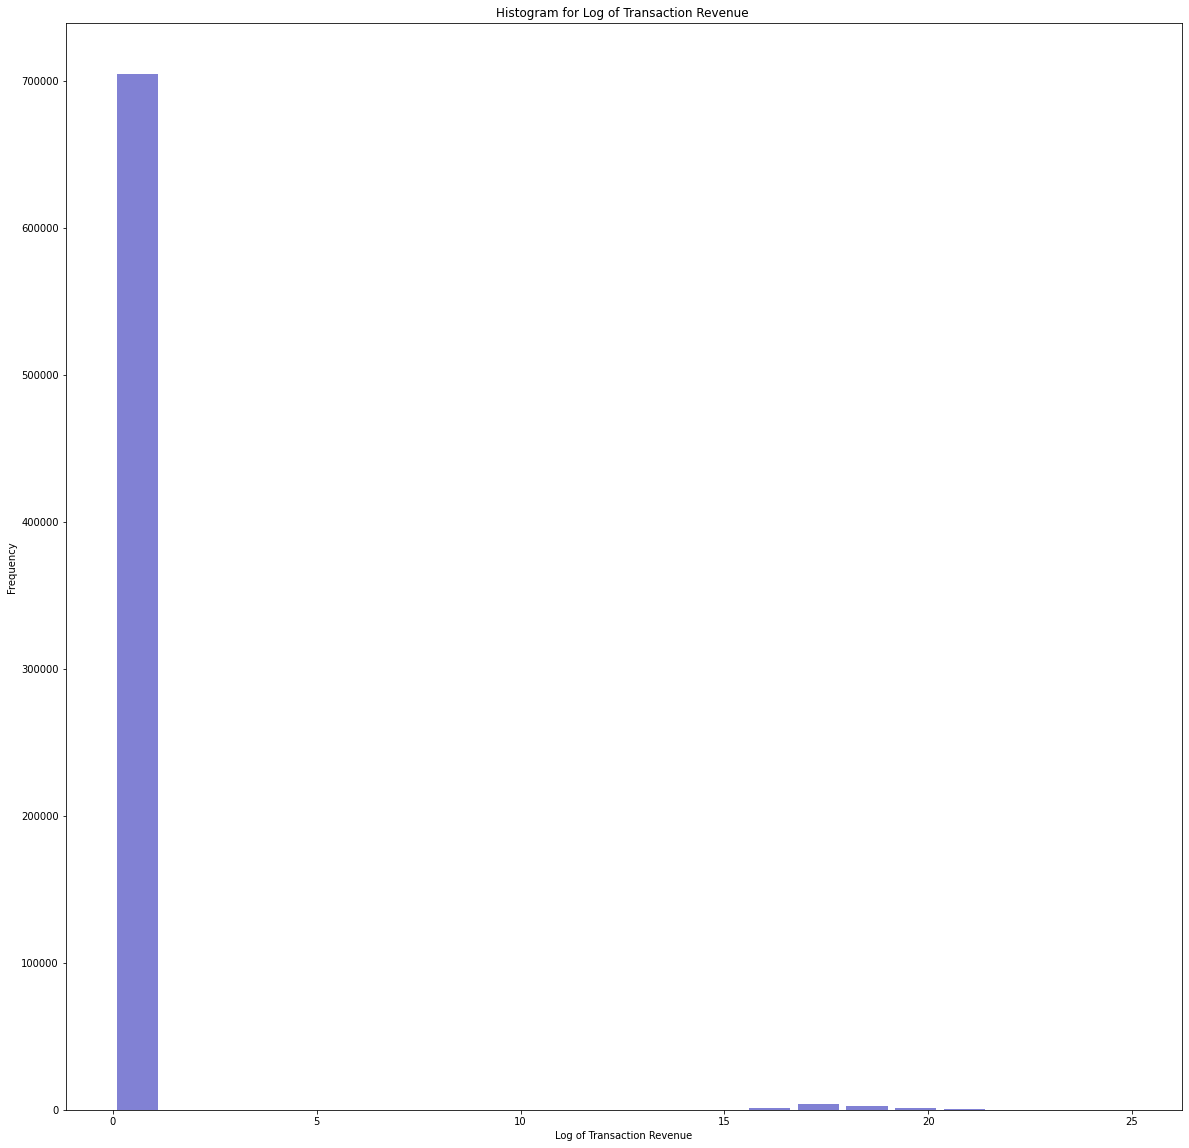

In [ ]:
plt.hist(x=target, bins='auto', color='#0504aa',
                            alpha=0.5, rwidth=0.85)
plt.xlabel('Log of Transaction Revenue')
plt.ylabel('Frequency')
plt.title('Histogram for Log of Transaction Revenue ')

In [ ]:
target.value_counts()
print('Percentage of users that would not make a transaction is:',round(target[target == 0 ].count()/len(target)*100,2),'%')
print('Percentage of users that would make a transaction is:',round(target[target > 0 ].count()/len(target)*100,2),'%')

Percentage of users that would not make a transaction is: 98.6 %
Percentage of users that would make a transaction is: 1.4 %


Text(0.5, 1.0, 'Distribuition of Target Variable that is not 0')

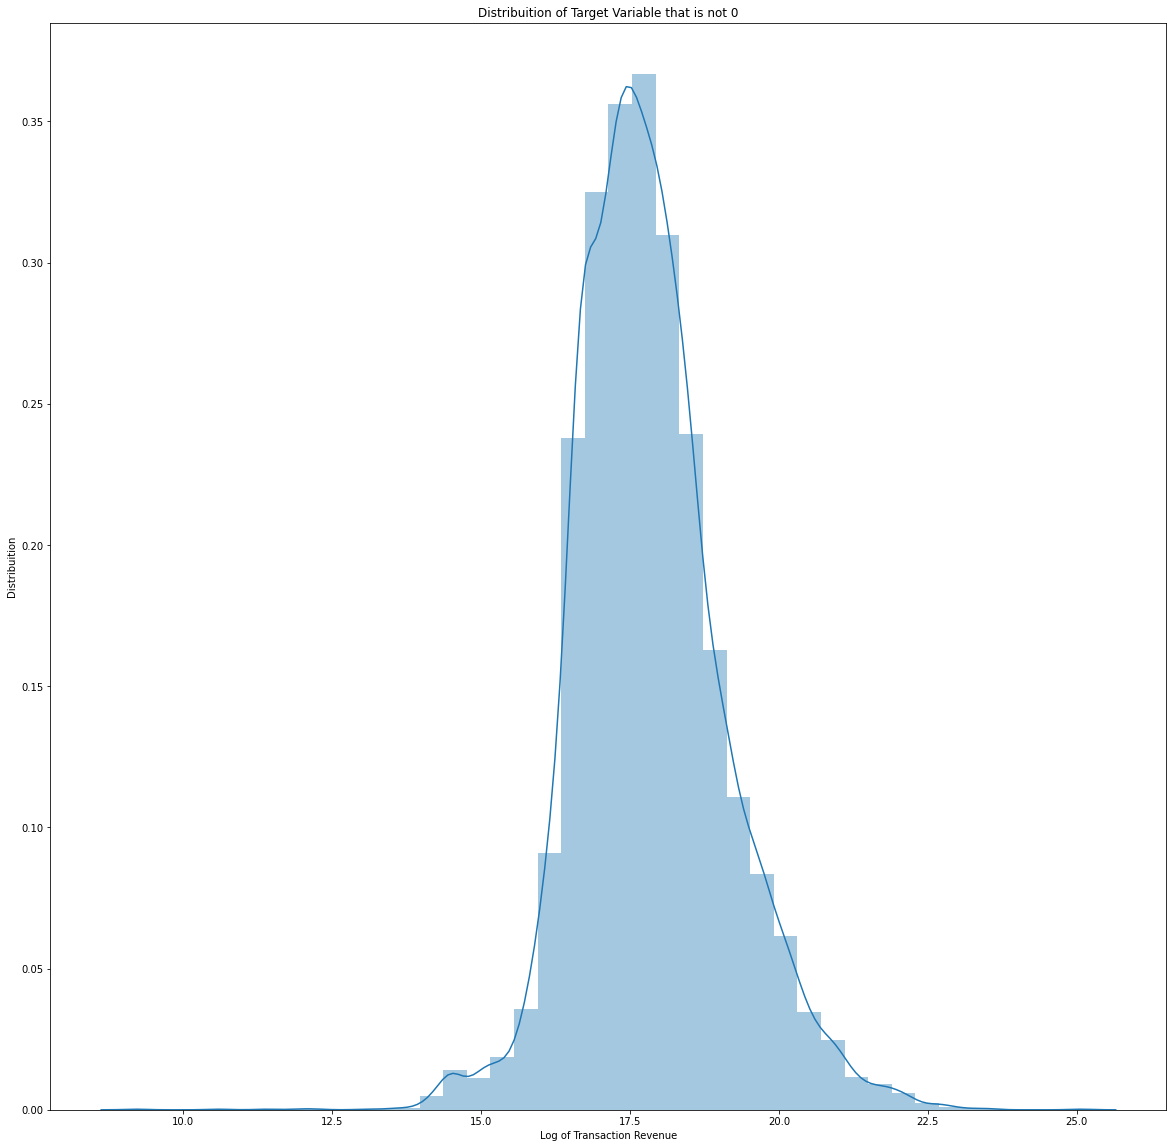

In [ ]:
ax = sns.distplot(target[target>0], bins=40, kde=True)
ax.set_xlabel('Log of Transaction Revenue', ) 
ax.set_ylabel('Distribuition') 
ax.set_title("Distribuition of Target Variable that is not 0") 

In [ ]:
#Sijia 

Text(0.5, 1.0, 'Average log_revenue from Different Countinents')

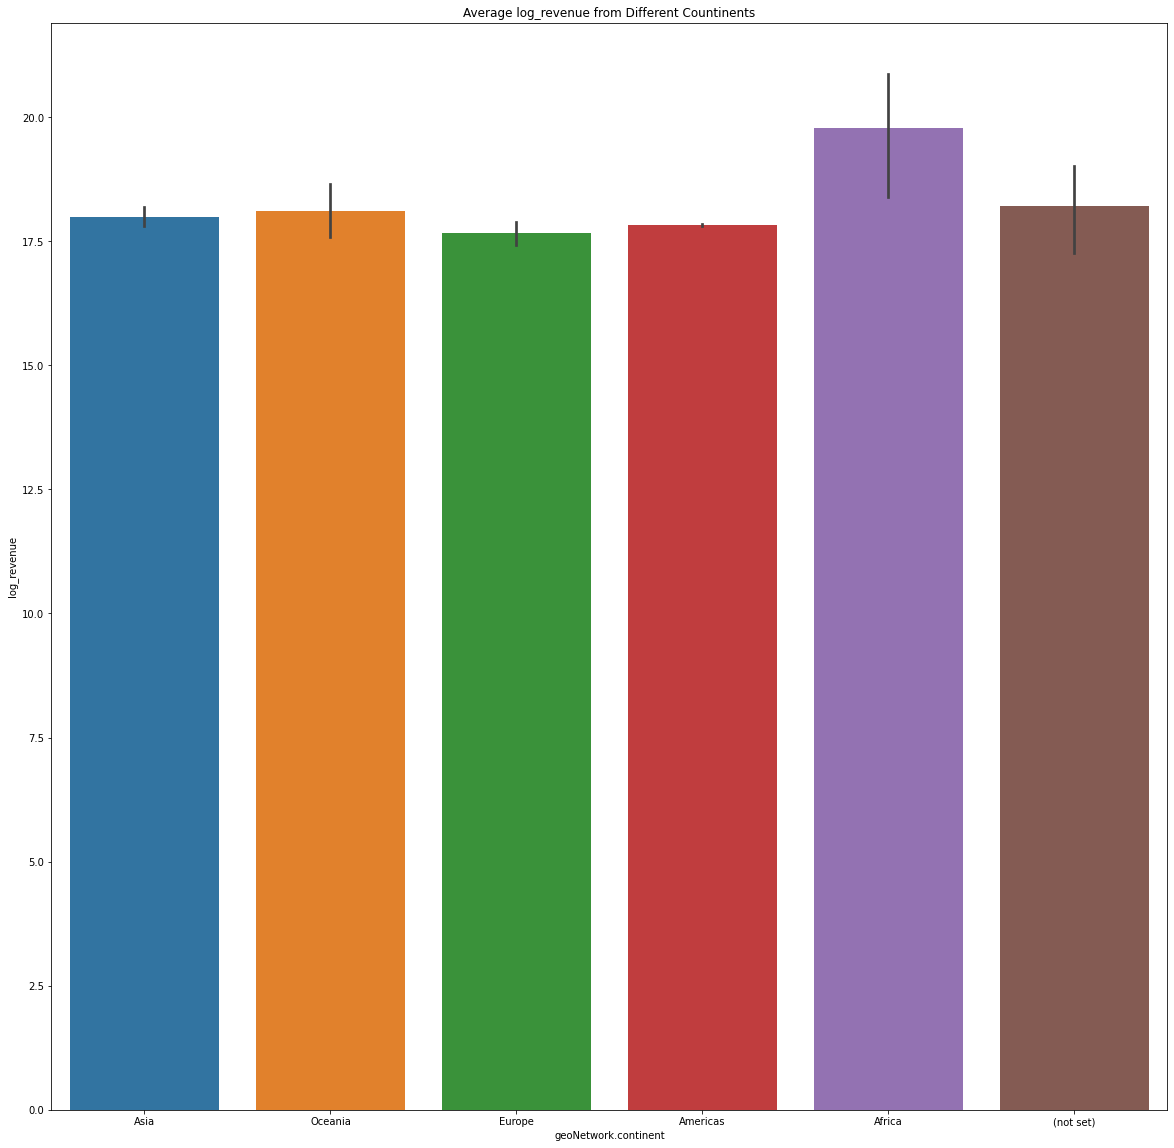

In [ ]:
#continent vs log_revenue
log_revenue=np.log1p(df_train['totals.transactionRevenue'] )
df_train['log_revenue']=log_revenue
sns.barplot(x='geoNetwork.continent', y='log_revenue', data=df_train).set_title('Average log_revenue from Different Countinents')

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 56 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   channelGrouping                                    903653 non-null  object 
 1   date                                               903653 non-null  int64  
 2   fullVisitorId                                      903653 non-null  object 
 3   sessionId                                          903653 non-null  object 
 4   socialEngagementType                               903653 non-null  object 
 5   visitId                                            903653 non-null  int64  
 6   visitNumber                                        903653 non-null  int64  
 7   visitStartTime                                     903653 non-null  int64  
 8   device.browser                                     903653 non-null  object

In [ ]:
#device
lr_device=pd.pivot_table(df_train, values='log_revenue', index=['device.deviceCategory', 'device.operatingSystem'], aggfunc=np.sum)
cm = sns.light_palette("green", as_cmap=True)
lr_device.style.background_gradient(cmap=cm)

In [ ]:
#sources
lr_source=pd.pivot_table(df_train, values='log_revenue', index=['trafficSource.source'], aggfunc=np.mean)
cm = sns.light_palette("green", as_cmap=True)
lr_source.style.background_gradient(cmap=cm)


,log_revenue
trafficSource.source,
(direct),18.033891
Partners,17.141930
ask,15.713248
basecamp.com,18.477061
bing,17.279366
calendar.google.com,17.808929
chat.google.com,18.005620
connect.googleforwork.com,18.447529
dealspotr.com,18.155345


In [ ]:
# Jiekai

In [ ]:
df_train.info()

In [ ]:
df_train.head()

In [ ]:
# date vs target
# change the date column from integer to date 
date = df_train['date'].astype(str).apply(lambda x: pd.to_datetime(x,format = '%Y%m%d'))

NameError: ignored

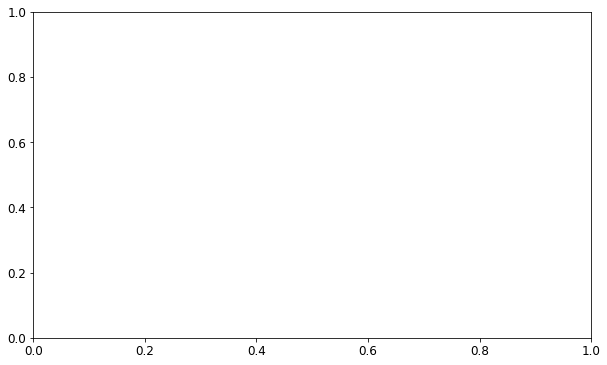

In [ ]:
# the plot of target variables based on time
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))
# Specify how the lines should look
ax.plot(date, np.log1p(df_train['totals.transactionRevenue']), color='tab:orange', label='log Revenue')
ax.plot(date, df_train['totals.transactionRevenue'], color='tab:blue', label='Revenue')
ax.set_xlabel('Time')
ax.set_ylabel('Revenue')
ax.set_title('Revenue Based on Time')
ax.grid(True)
ax.legend(loc='upper left')

In [ ]:
# device is mobile
plt.bar(x = ['False','True'],height = df_train['device.isMobile'].value_counts())
plt.xlabel('Is mobile or not')
plt.ylabel('Count')
plt.title('Mobile Device Counts')


In [ ]:
# non - modile device revenue
nonmoblie = df_train[df_train['device.isMobile']==False]
moblie = df_train[df_train['device.isMobile']==True]
plt.bar(x = ['False','True'],height = [nonmoblie['totals.transactionRevenue'].sum(),moblie['totals.transactionRevenue'].sum()])
plt.xlabel('Is mobile or not')
plt.ylabel('Revenue')
plt.title('Revenue based on IsMobile')

In [ ]:
# operation system
# At index I will use isin to substitute the loop and get just the values with more than 1%
crosstab_eda = pd.crosstab(index=df_train[df_train['device.operatingSystem']\
                                          .isin(df_train['device.operatingSystem']\
                                                .value_counts()[:6].index.values)]['device.operatingSystem'], 
                           
                           # at this line, I am using the isin to select just the top 5 of browsers
                           columns=df_train[df_train['device.browser'].isin(df_train['device.browser']\
                                                                            .value_counts()[:5].index.values)]['device.browser'])
# Ploting the crosstab that we did above
crosstab_eda.plot(kind="bar",    # select the bar to plot the count of categoricals
                 figsize=(14,7), # adjusting the size of graphs
                 stacked=True)   # code to unstack 
plt.title("Most frequent OS's by Browsers of users", fontsize=22) # adjusting title and fontsize
plt.xlabel("Operational System Name", fontsize=19) # adjusting x label and fontsize
plt.ylabel("Count OS", fontsize=19) # adjusting y label and fontsize
plt.xticks(rotation=0) # Adjust the xticks, rotating the labels

plt.show() # rendering

In [ ]:
# Renjie

In [ ]:
# Check the corelation of the numerical variables
sns.set(font_scale=1.6)
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_train.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [ ]:
# Rank correlation with the target variable
plt.figure(figsize=(8, 12))
sns.set(font_scale=1.6)
heatmap = sns.heatmap(df_train.corr()[['totals.transactionRevenue']].sort_values(by='totals.transactionRevenue', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with totals.transactionRevenue', fontdict={'fontsize':30}, pad=16);

In [ ]:
#Visualize Transaction Revenue vs visitnumber
sns.jointplot(y = 'totals.transactionRevenue',  x = 'visitNumber', data=df_train,
              kind="scatter", color="g");

In [ ]:
def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace


from plotly import tools
import plotly.offline as py

In [ ]:
# Continent
cnt_srs = df_train.groupby('trafficSource.source')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'green')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'green')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'green')

# Sub-continent
cnt_srs = df_train.groupby('trafficSource.medium')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'purple')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'purple')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'purple')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Traffic Source - Count", "Traffic Source - Non-zero Revenue Count", "Traffic Source - Mean Revenue",
                                          "Traffic Source Medium - Count",  "Traffic Source Medium - Non-zero Revenue Count", "Traffic Source Medium - Mean Revenue"
                                          ])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1000, width=1200, paper_bgcolor='rgb(233,233,233)', title="Traffic Source Plots")
py.iplot(fig, filename='traffic-source-plots')

### 2. Data Preprocessing

In [ ]:
df_train = pd.read_csv('df_train.csv')
df_train.shape

(903653, 56)

In [ ]:
#drop the columns that are not available in demo
columns_not_available=df_train.iloc[1,:][df_train.iloc[1,:]=='not available in demo dataset'].index
df_train_all_available=df_train.drop(columns=columns_not_available)

In [ ]:
#drop the columns that has more than 30% of missing values  
null_columns=df_train_all_available.columns[df_train_all_available.isnull().sum()/len(df_train_all_available)>0.3]
df_train_available_notnull=df_train_all_available.drop(columns=null_columns)
#add back the taeget variable 
df_train_available_notnull['totals.transactionRevenue']=df_train_all_available['totals.transactionRevenue']

In [ ]:
# fill zeros for the missing values in the target variable 
df_train_available_notnull['totals.transactionRevenue'] = df_train_available_notnull['totals.transactionRevenue'] .fillna(0)

In [ ]:
df_train_available_notnull.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 903653 non-null  int64  
 1   channelGrouping            903653 non-null  object 
 2   date                       903653 non-null  int64  
 3   fullVisitorId              903653 non-null  object 
 4   sessionId                  903653 non-null  object 
 5   socialEngagementType       903653 non-null  object 
 6   visitId                    903653 non-null  int64  
 7   visitNumber                903653 non-null  int64  
 8   visitStartTime             903653 non-null  int64  
 9   device.browser             903653 non-null  object 
 10  device.operatingSystem     903653 non-null  object 
 11  device.isMobile            903653 non-null  bool   
 12  device.deviceCategory      903653 non-null  object 
 13  geoNetwork.continent       90

In [ ]:
#train_encoded=pd.get_dummies(df_train_available_notnull)

In [ ]:
df_train_available_notnull.sample(10)

,Unnamed: 0,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.networkDomain,totals.visits,totals.hits,totals.pageviews,totals.newVisits,trafficSource.campaign,trafficSource.source,trafficSource.medium,totals.transactionRevenue
537419,537419,Social,20170219,5088989242583385481,5088989242583385481_1487520411,Not Socially Engaged,1487520411,1,1487520411,Edge,Windows,False,desktop,Americas,Northern America,United States,verizon.net,1,1,1.0,1.0,(not set),youtube.com,referral,0.0
50257,50257,Organic Search,20170624,0316063145559908242,0316063145559908242_1498292354,Not Socially Engaged,1498292354,1,1498292354,Chrome,Windows,False,desktop,Asia,Southern Asia,Sri Lanka,slt.lk,1,32,30.0,1.0,(not set),google,organic,0.0
54557,54557,Referral,20170529,6079332925846512370,6079332925846512370_1496059169,Not Socially Engaged,1496059169,1,1496059169,Chrome,Macintosh,False,desktop,Asia,Eastern Asia,Japan,nuro.jp,1,2,2.0,1.0,(not set),qiita.com,referral,0.0
760148,760148,Organic Search,20170526,6835462665586933727,6835462665586933727_1495848315,Not Socially Engaged,1495848315,1,1495848315,Safari,iOS,True,tablet,Oceania,Australasia,Australia,telstra.net,1,5,3.0,1.0,(not set),google,organic,0.0
676104,676104,Organic Search,20160815,230701588685937364,230701588685937364_1471286692,Not Socially Engaged,1471286692,2,1471286692,Chrome,Windows,False,desktop,Asia,Western Asia,Israel,unknown.unknown,1,3,3.0,NaN,(not set),google,organic,0.0
203537,203537,Organic Search,20170606,9098674951788305438,9098674951788305438_1496780997,Not Socially Engaged,1496780997,3,1496780997,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,(not set),1,2,2.0,NaN,(not set),google,organic,0.0
582298,582298,Social,20161116,6510776761908785039,6510776761908785039_1479304530,Not Socially Engaged,1479304530,1,1479304530,Safari,Macintosh,False,desktop,Asia,Western Asia,Azerbaijan,unknown.unknown,1,1,1.0,1.0,(not set),youtube.com,referral,0.0
139193,139193,Organic Search,20170320,7900571925123939049,7900571925123939049_1490036904,Not Socially Engaged,1490036904,1,1490036904,Firefox,Windows,False,desktop,Asia,Southern Asia,India,in,1,1,1.0,1.0,(not set),google,organic,0.0
798557,798557,Organic Search,20170418,6596626487478581226,6596626487478581226_1492499210,Not Socially Engaged,1492499210,1,1492499210,Internet Explorer,Windows,False,desktop,Asia,Eastern Asia,Japan,ucom.ne.jp,1,2,2.0,1.0,(not set),bing,organic,0.0
239545,239545,Organic Search,20170503,8194906584823233059,8194906584823233059_1493815387,Not Socially Engaged,1493815387,1,1493815387,Safari,Macintosh,False,desktop,Americas,Northern America,United States,verizon.net,1,1,1.0,1.0,(not set),google,organic,0.0


In [ ]:
df_train_available_notnull.nunique()

Unnamed: 0                   903653
channelGrouping                   8
date                            366
fullVisitorId                723803
sessionId                    902755
socialEngagementType              1
visitId                      886303
visitNumber                     384
visitStartTime               887159
device.browser                   54
device.operatingSystem           20
device.isMobile                   2
device.deviceCategory             3
geoNetwork.continent              6
geoNetwork.subContinent          23
geoNetwork.country              222
geoNetwork.networkDomain      28064
totals.visits                     1
totals.hits                     274
totals.pageviews                213
totals.newVisits                  1
trafficSource.campaign           10
trafficSource.source            380
trafficSource.medium              7
totals.transactionRevenue      5333
dtype: int64

In [ ]:
df_train_available_notnull.drop(df_train_available_notnull.columns[[0, 2, 3,4,5,6,8,9,10,14,15,16,17,20,22]], axis = 1, inplace = True)

In [ ]:
df_train_available_notnull.nunique()

channelGrouping                 8
visitNumber                   384
device.isMobile                 2
device.deviceCategory           3
geoNetwork.continent            6
totals.hits                   274
totals.pageviews              213
trafficSource.campaign         10
trafficSource.medium            7
totals.transactionRevenue    5333
dtype: int64

In [ ]:
df_train_available_notnull = df_train_available_notnull.dropna()
df_train_available_notnull.shape

(903553, 10)

In [ ]:
train_encoded=pd.get_dummies(df_train_available_notnull, columns=['channelGrouping','device.isMobile','device.deviceCategory',
                                                                  'geoNetwork.continent','trafficSource.campaign','trafficSource.medium'])

In [ ]:
train_encoded.sample(10)

,visitNumber,totals.hits,totals.pageviews,totals.transactionRevenue,channelGrouping_(Other),channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Display,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,device.isMobile_False,device.isMobile_True,device.deviceCategory_desktop,device.deviceCategory_mobile,device.deviceCategory_tablet,geoNetwork.continent_(not set),geoNetwork.continent_Africa,geoNetwork.continent_Americas,geoNetwork.continent_Asia,geoNetwork.continent_Europe,geoNetwork.continent_Oceania,trafficSource.campaign_(not set),trafficSource.campaign_AW - Accessories,trafficSource.campaign_AW - Apparel,trafficSource.campaign_AW - Dynamic Search Ads Whole Site,trafficSource.campaign_AW - Electronics,trafficSource.campaign_All Products,trafficSource.campaign_Data Share,trafficSource.campaign_Data Share Promo,trafficSource.campaign_Retail (DO NOT EDIT owners nophakun and tianyu),trafficSource.campaign_test-liyuhz,trafficSource.medium_(none),trafficSource.medium_(not set),trafficSource.medium_affiliate,trafficSource.medium_cpc,trafficSource.medium_cpm,trafficSource.medium_organic,trafficSource.medium_referral
216037,1,9,6.0,0.0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
117215,1,1,1.0,0.0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
508167,1,1,1.0,0.0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
891219,1,1,1.0,0.0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
155947,1,1,1.0,0.0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
399143,1,1,1.0,0.0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
541379,1,1,1.0,0.0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
269322,2,1,1.0,0.0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
33392,1,1,1.0,0.0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
422855,2,1,1.0,0.0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
#identify target variable and independent variable 
y=train_encoded['totals.transactionRevenue']
y = np.log1p(y)
X=train_encoded.drop(['totals.transactionRevenue'],1)
#split into train and test data
X_train,X_test,y_train,y_test=train_test_split(X,y, train_size=0.8, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(722842, 39)
(180711, 39)
(722842,)
(180711,)


### 3. Modeling

####  LightGBM

In [ ]:
#find the best hyper parameters 
# Create the parameter grid based on the definition of the problem
param_grid = {
    'num_leaves':[20,30,50,70],
    'max_depth': [30,50,70,90,100],
    'feature_fraction': [0.6,0.7,0.8,0.9]
}
# Create a based model
lgbm_model = LGBMRegressor(n_estimators=100,random_state=0)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = lgbm_model, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
#fit the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 20.2min finished


{'feature_fraction': 0.9, 'max_depth': 30, 'num_leaves': 30}

In [ ]:
#fit model
lgbm_model = LGBMRegressor(n_estimators=100,random_state=0,feature_fraction=0.9, max_depth=30, num_leaves=30).fit(X_train, y_train)
#feature selection
lgbm_features=X_train.columns[lgbm_model.feature_importances_>5]

#fit model with the important features 
lgbm_model_fs=LGBMRegressor(n_estimators=100,random_state=0,feature_fraction=0.9, max_depth=30, num_leaves=30).fit(X_train[lgbm_features], y_train)
#predict 
lgbm_model_fs_pred=lgbm_model_fs.predict(X_test[lgbm_features])
#performance (rmse)
lgbm_model_fs_train_rmse=math.sqrt(statistics.mean(-cross_val_score(lgbm_model_fs, X_train[lgbm_features], y_train, cv=5, scoring='neg_mean_squared_error')))
lgbm_model_fs_test_rmse=math.sqrt(statistics.mean(-cross_val_score(lgbm_model_fs, X_test[lgbm_features], y_test, cv=5, scoring='neg_mean_squared_error')))
print(lgbm_model_fs_train_rmse)
print(lgbm_model_fs_test_rmse)

1.6612313941966983
1.7090455661877857


In [ ]:
lgbm_model.feature_importances_

array([531, 875, 876,   0,   6,  61,  23,  53,   9,  84,  17,  48,   8,
        33,  15,  10,   0,   0, 141,  14,   9,   0,   8,  11,   0,  13,
         6,   0,   0,   3,   0,   0,  11,   0,   0,   1,   2,   7,  25])

In [ ]:
lgbm_features

Index(['visitNumber', 'totals.hits', 'totals.pageviews',
       'channelGrouping_Affiliates', 'channelGrouping_Direct',
       'channelGrouping_Display', 'channelGrouping_Organic Search',
       'channelGrouping_Paid Search', 'channelGrouping_Referral',
       'channelGrouping_Social', 'device.isMobile_False',
       'device.isMobile_True', 'device.deviceCategory_desktop',
       'device.deviceCategory_mobile', 'device.deviceCategory_tablet',
       'geoNetwork.continent_Americas', 'geoNetwork.continent_Asia',
       'geoNetwork.continent_Europe', 'trafficSource.campaign_(not set)',
       'trafficSource.campaign_AW - Accessories',
       'trafficSource.campaign_AW - Dynamic Search Ads Whole Site',
       'trafficSource.campaign_AW - Electronics',
       'trafficSource.medium_(none)', 'trafficSource.medium_organic',
       'trafficSource.medium_referral'],
      dtype='object')

In [ ]:
%%time
#fit model with 'min_data_in_leaf' to see if there is overfitting problem
lgbm_model = LGBMRegressor(n_estimators=100,random_state=0,feature_fraction=0.9, max_depth=30, num_leaves=30,min_data_in_leaf=300).fit(X_train, y_train)
#feature selection
lgbm_features=X_train.columns[lgbm_model.feature_importances_>5]

#fit model with the important features 
lgbm_model_fs=LGBMRegressor(n_estimators=100,random_state=0,feature_fraction=0.9, max_depth=30, num_leaves=30,min_data_in_leaf=300).fit(X_train[lgbm_features], y_train)
#predict 
lgbm_model_fs_pred=lgbm_model_fs.predict(X_test[lgbm_features])
#performance (rmse)
lgbm_model_fs_train_rmse=math.sqrt(statistics.mean(-cross_val_score(lgbm_model_fs, X_train[lgbm_features], y_train, cv=5, scoring='neg_mean_squared_error')))
lgbm_model_fs_test_rmse=math.sqrt(statistics.mean(-cross_val_score(lgbm_model_fs, X_test[lgbm_features], y_test, cv=5, scoring='neg_mean_squared_error')))
print(lgbm_model_fs_train_rmse)
print(lgbm_model_fs_test_rmse)

1.65964043745461
1.6946854375590736
CPU times: user 56.5 s, sys: 314 ms, total: 56.8 s
Wall time: 29.9 s


In [ ]:
lgbm_model.feature_importances_

array([ 406, 1015,  940,    0,    6,   50,    6,   60,    1,   88,   14,
         57,    7,   39,    8,    0,    0,    0,  148,    3,    6,    0,
          2,    1,    0,    0,    0,    0,    0,    0,    0,    0,    7,
          0,    0,    0,    2,   12,   22])

In [ ]:
lgbm_features

Index(['visitNumber', 'totals.hits', 'totals.pageviews',
       'channelGrouping_Affiliates', 'channelGrouping_Direct',
       'channelGrouping_Display', 'channelGrouping_Organic Search',
       'channelGrouping_Referral', 'channelGrouping_Social',
       'device.isMobile_False', 'device.isMobile_True',
       'device.deviceCategory_desktop', 'device.deviceCategory_mobile',
       'geoNetwork.continent_Americas', 'geoNetwork.continent_Europe',
       'trafficSource.medium_(none)', 'trafficSource.medium_organic',
       'trafficSource.medium_referral'],
      dtype='object')

####XGB

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
def mod_xgb(X_train,y_train,X_test,y_test):
  params = {'objective': 'reg:linear',
              'eval_metric': 'rmse',
              'eta': 0.005,
              'max_depth': 10,
              'colsample_bytree': 0.6,
              'alpha':0.001,
              'random_state': 24,
              'silent':True}
  xgb_train  = xgb.DMatrix(X_train,y_train)
  xgb_test = xgb.DMatrix(X_test,y_test)
  evals = [(xgb_train,'train'), (xgb_test,'valid')]
  #XGB Model
  xgb_model  = xgb.train(params, xgb_train, num_boost_round=200, 
                        evals = evals,
                        early_stopping_rounds = 100,
                         verbose_eval = 10)
  #Predict
  y_pred_train=xgb_model.predict(xgb_train, ntree_limit=xgb_model.best_ntree_limit)
  y_pred_test=xgb_model.predict(xgb_test, ntree_limit=xgb_model.best_ntree_limit)
  #performance (rmse)
  xgb_train_rmse = sqrt(mean_squared_error(y_train, y_pred_train))
  xgb_test_rmse = sqrt(mean_squared_error(y_test, y_pred_test))
  print(f"XGB : RMSE test: {xgb_test_rmse}  - RMSE train: {xgb_train_rmse}")
  return xgb_model

In [ ]:
%%time
xgbpred = mod_xgb(X_train,y_train,X_test,y_test)

[0]	train-rmse:2.01584	valid-rmse:2.03552
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[10]	train-rmse:1.99147	valid-rmse:2.0084
[20]	train-rmse:1.96475	valid-rmse:1.98556
[30]	train-rmse:1.93683	valid-rmse:1.96249
[40]	train-rmse:1.91948	valid-rmse:1.94437
[50]	train-rmse:1.90077	valid-rmse:1.9292
[60]	train-rmse:1.88327	valid-rmse:1.91152
[70]	train-rmse:1.86608	valid-rmse:1.89398
[80]	train-rmse:1.85264	valid-rmse:1.8799
[90]	train-rmse:1.83938	valid-rmse:1.86645
[100]	train-rmse:1.82394	valid-rmse:1.85499
[110]	train-rmse:1.8122	valid-rmse:1.84439
[120]	train-rmse:1.799	valid-rmse:1.83245
[130]	train-rmse:1.78991	valid-rmse:1.82313
[140]	train-rmse:1.77746	valid-rmse:1.81286
[150]	train-rmse:1.76713	valid-rmse:1.80349
[160]	train-rmse:1.75728	valid-rmse:1.79396
[170]	train-rmse:1.75035	valid-rmse:1.78773
[180]	train-rmse:1.7428	valid-rmse:1.78083
[190]	train-rmse:1.73523	valid-rmse:

In [ ]:
#Cross-validation
arams = {'objective': 'reg:linear',
              'eval_metric': 'rmse',
              'eta': 0.005,
              'max_depth': 10,
              'colsample_bytree': 0.6,
              'alpha':0.001,
              'random_state': 24,
              'silent':True}
data_dmatrix = xgb.DMatrix(data=X,label=y)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,2.019766,0.004126,2.019895,0.008270
1,2.017079,0.004069,2.017298,0.008318
2,2.014615,0.004140,2.014949,0.008218
3,2.012584,0.005259,2.012614,0.007124
4,2.009892,0.005233,2.009936,0.007167
5,2.007383,0.005539,2.007522,0.006959
6,2.003648,0.005762,2.002548,0.006521
7,2.002118,0.006639,2.001036,0.005773
8,1.999619,0.006555,1.998510,0.005934
9,1.997037,0.006432,1.995698,0.006005


In [ ]:
#Hyperparameter (eta, colsample)
dtrain  = xgb.DMatrix(X_train,y_train)
gridsearch_params = [
    (eta, colsample)
    for eta in [.05, .01, .005]
    for colsample in [i/10. for i in range(6,9)]
]

min_rmse = float("Inf")
best_params = None

for eta, colsample in (gridsearch_params):
    print("CV with eta={}, colsample={}".format(
                             eta,
                             colsample))
    #update parameters
    params['eta'] = eta
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=30,
        seed=34,
        nfold=3,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (eta,colsample)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with eta=0.05, colsample=0.6
	RMSE 1.7057346666666666 for 29 rounds
CV with eta=0.05, colsample=0.7
	RMSE 1.6931510000000003 for 29 rounds
CV with eta=0.05, colsample=0.8
	RMSE 1.6880513333333331 for 29 rounds
CV with eta=0.01, colsample=0.6
	RMSE 1.8929953333333334 for 29 rounds
CV with eta=0.01, colsample=0.7
	RMSE 1.8819956666666666 for 29 rounds
CV with eta=0.01, colsample=0.8
	RMSE 1.8751666666666669 for 29 rounds
CV with eta=0.005, colsample=0.6
	RMSE 1.9494323333333334 for 29 rounds
CV with eta=0.005, colsample=0.7
	RMSE 1.9429216666666669 for 29 rounds
CV with eta=0.005, colsample=0.8
	RMSE 1.9388606666666668 for 29 rounds
Best params: 0.05, 0.8, RMSE: 1.6880513333333331


In [ ]:
#Train with new Hyperparameter
params = {'objective': 'reg:linear',
              'eval_metric': 'rmse',
              'eta': 0.05,
              'max_depth': 10,
              'colsample_bytree': 0.8,
              'alpha':0.001,
              'random_state': 24,
              'silent':True}
xgb_train  = xgb.DMatrix(X_train,y_train)
xgb_test = xgb.DMatrix(X_test,y_test)
evals = [(xgb_train,'train'), (xgb_test,'valid')]
#XGB Model
xgb_model  = xgb.train(params, xgb_train, num_boost_round=200, 
                        evals = evals,
                        early_stopping_rounds = 100,
                         verbose_eval = 10)
#Predict
y_pred_train=xgb_model.predict(xgb_train, ntree_limit=xgb_model.best_ntree_limit)
y_pred_test=xgb_model.predict(xgb_test, ntree_limit=xgb_model.best_ntree_limit)
#Feature Importance
feature_important = xgb_model.get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
xgb_importance = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
xgb_importance = xgb_importance[xgb_importance.score > 500]

[0]	train-rmse:1.98886	valid-rmse:2.00595
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[10]	train-rmse:1.77294	valid-rmse:1.81192
[20]	train-rmse:1.67825	valid-rmse:1.73429
[30]	train-rmse:1.63403	valid-rmse:1.70094
[40]	train-rmse:1.61017	valid-rmse:1.68617
[50]	train-rmse:1.59666	valid-rmse:1.68089
[60]	train-rmse:1.58133	valid-rmse:1.6776
[70]	train-rmse:1.57193	valid-rmse:1.67629
[80]	train-rmse:1.55979	valid-rmse:1.67589
[90]	train-rmse:1.54889	valid-rmse:1.67575
[100]	train-rmse:1.54133	valid-rmse:1.67627
[110]	train-rmse:1.53633	valid-rmse:1.67672
[120]	train-rmse:1.53257	valid-rmse:1.67742
[130]	train-rmse:1.52942	valid-rmse:1.67767
[140]	train-rmse:1.52657	valid-rmse:1.67825
[150]	train-rmse:1.52228	valid-rmse:1.67889
[160]	train-rmse:1.51875	valid-rmse:1.67901
[170]	train-rmse:1.51637	valid-rmse:1.67952
[180]	train-rmse:1.5131	valid-rmse:1.68002
Stopping. Best iteration:
[89]	

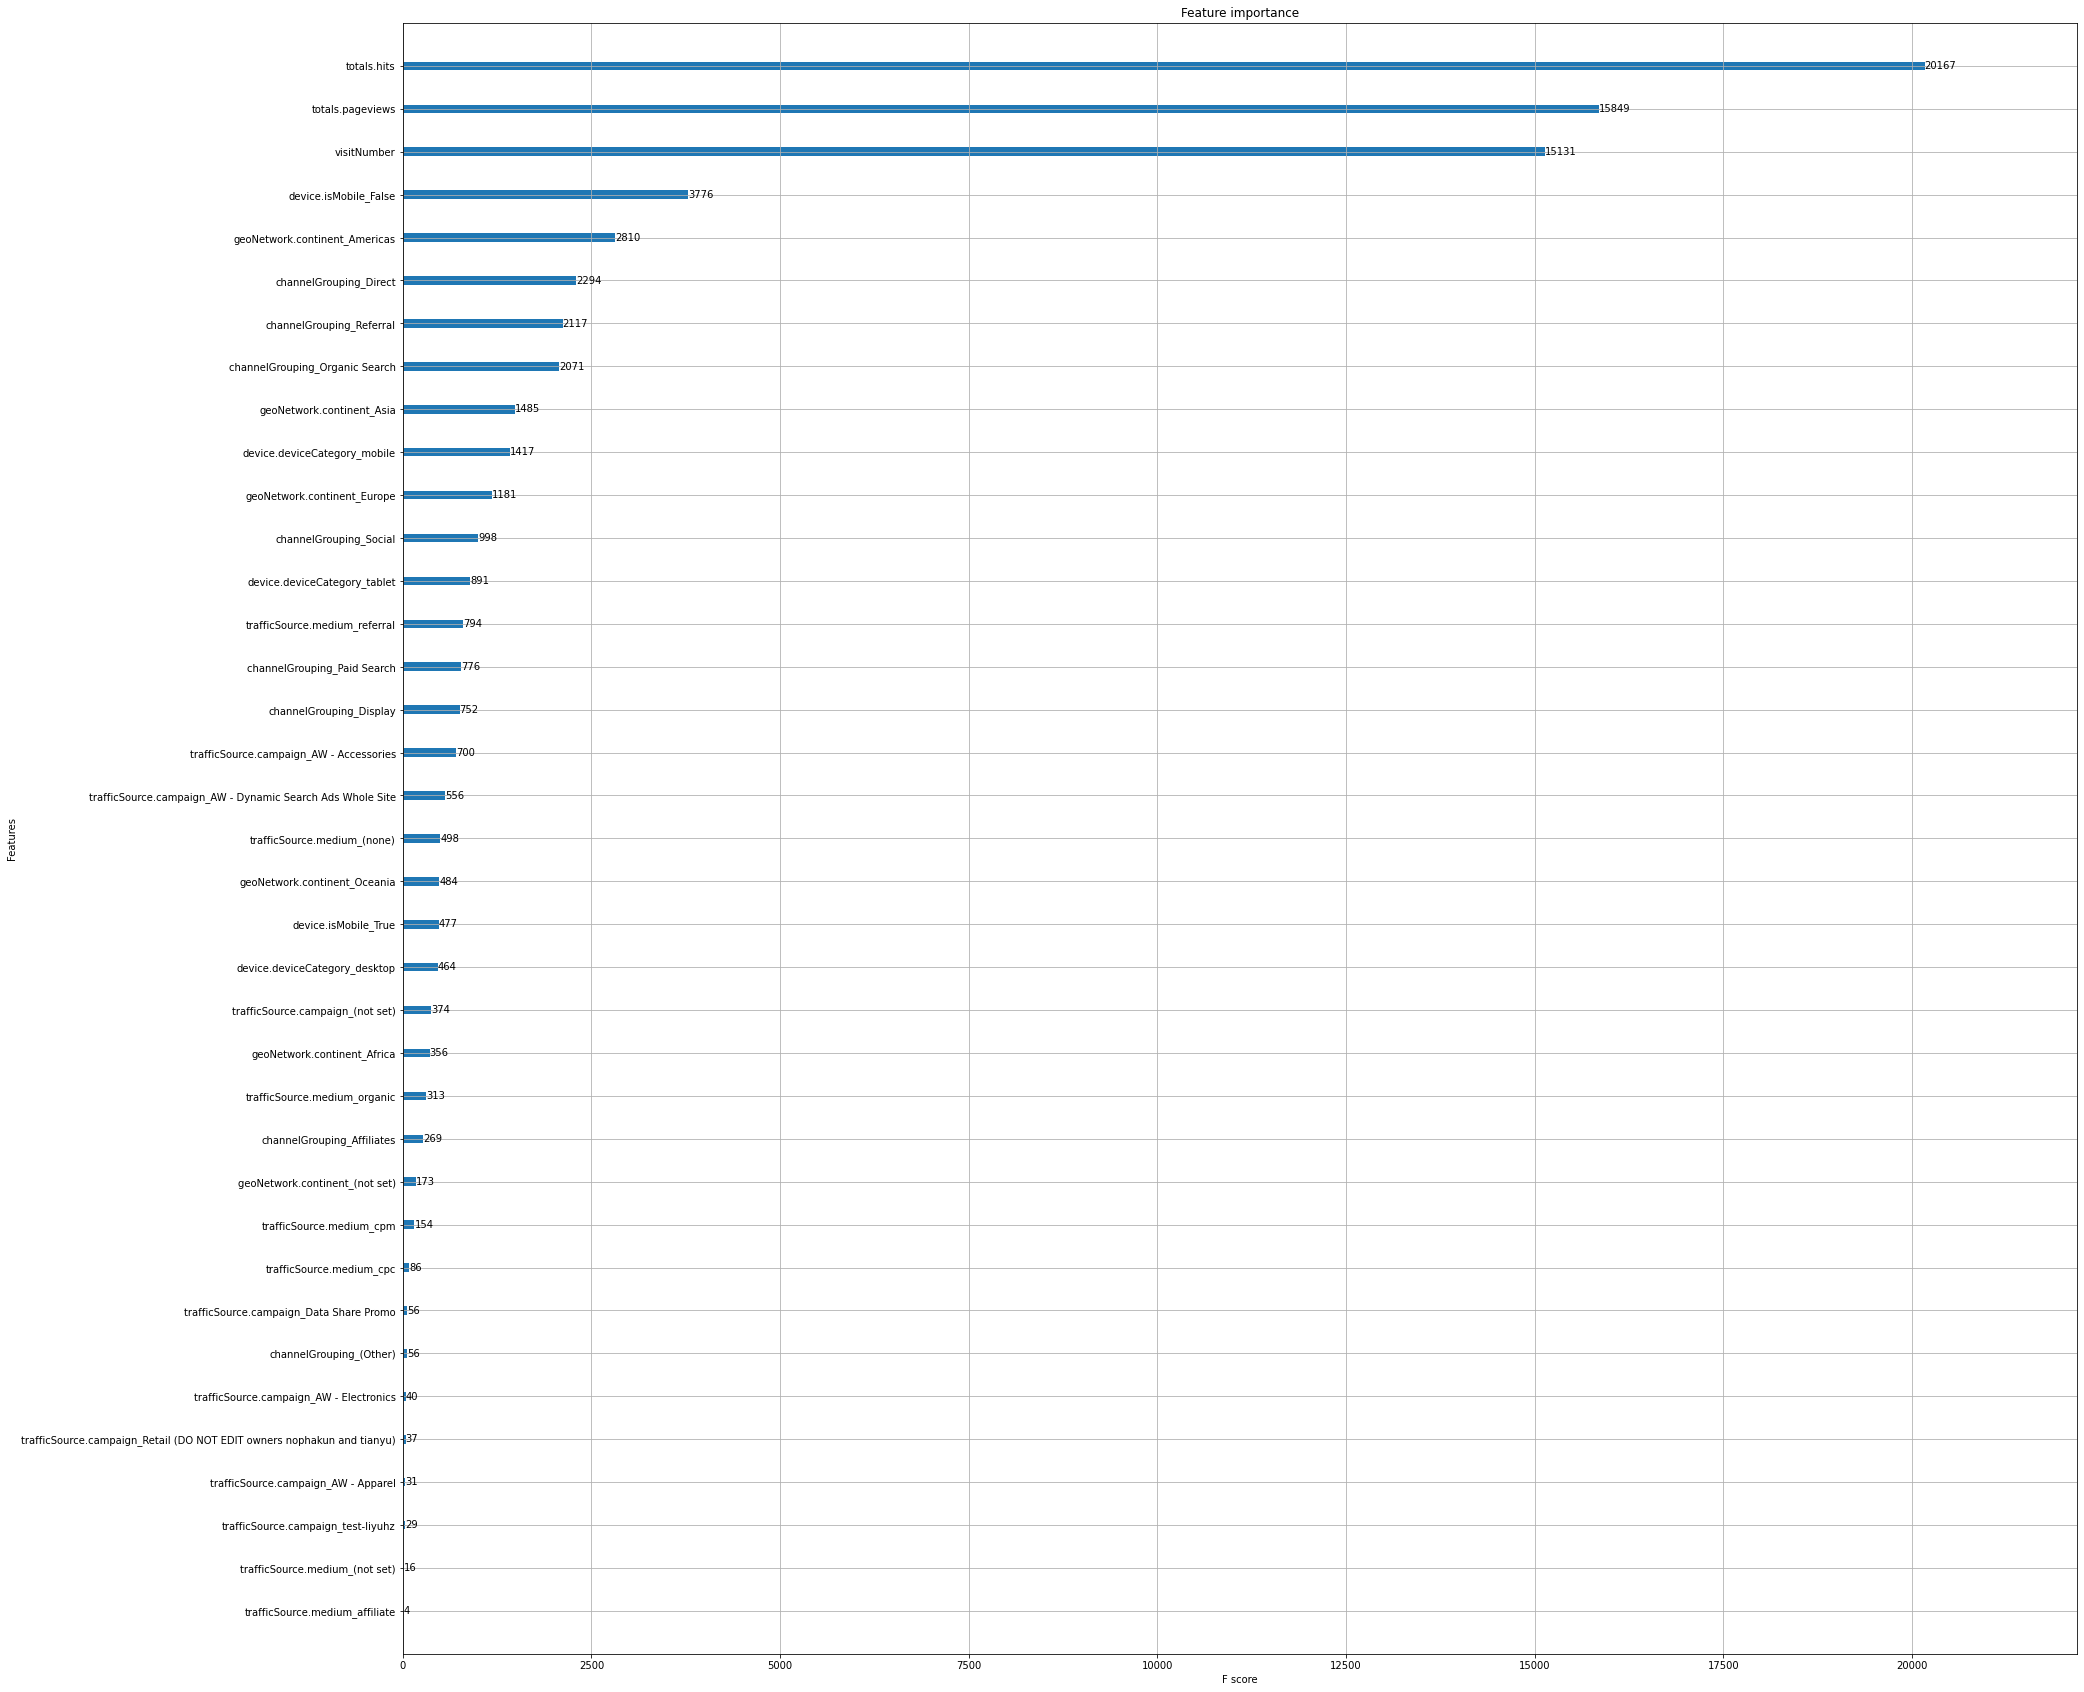

In [ ]:
xgb.plot_importance(xgb_model)
plt.rcParams['figure.figsize'] = [20,20]
plt.show()

In [ ]:
#Train with feature importance
%%time
xgb_train_fs  = xgb.DMatrix(X_train[xgb_importance.index],y_train)
xgb_test_fs = xgb.DMatrix(X_test[xgb_importance.index],y_test)
evals = [(xgb_train_fs,'train'), (xgb_test_fs,'valid')]
#XGB Model
xgb_model_fs  = xgb.train(params, xgb_train_fs, num_boost_round=200, 
                          evals = evals,
                        early_stopping_rounds = 100,
                         verbose_eval = 10)
#Predict
y_pred_train=xgb_model.predict(xgb_train, ntree_limit=xgb_model.best_ntree_limit)
y_pred_test=xgb_model.predict(xgb_test, ntree_limit=xgb_model.best_ntree_limit)
#Final Performance
xgb_train_rmse = sqrt(mean_squared_error(y_train, y_pred_train))
xgb_test_rmse = sqrt(mean_squared_error(y_test, y_pred_test))
print("-----------Train RMSE: {}------Test RMSE: {}".format(xgb_train_rmse, xgb_test_rmse))

[0]	train-rmse:2.01503	valid-rmse:2.03186
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[10]	train-rmse:1.79018	valid-rmse:1.82514
[20]	train-rmse:1.6846	valid-rmse:1.73791
[30]	train-rmse:1.64089	valid-rmse:1.70517
[40]	train-rmse:1.61762	valid-rmse:1.68976
[50]	train-rmse:1.59506	valid-rmse:1.68099
[60]	train-rmse:1.58175	valid-rmse:1.67844
[70]	train-rmse:1.57119	valid-rmse:1.67705
[80]	train-rmse:1.55843	valid-rmse:1.67714
[90]	train-rmse:1.55239	valid-rmse:1.67757
[100]	train-rmse:1.54278	valid-rmse:1.67804
[110]	train-rmse:1.53717	valid-rmse:1.67833
[120]	train-rmse:1.53189	valid-rmse:1.67847
[130]	train-rmse:1.52702	valid-rmse:1.67893
[140]	train-rmse:1.52335	valid-rmse:1.67972
[150]	train-rmse:1.52132	valid-rmse:1.68019
[160]	train-rmse:1.51753	valid-rmse:1.68052
[170]	train-rmse:1.5147	valid-rmse:1.68114
Stopping. Best iteration:
[74]	train-rmse:1.56682	valid-rmse:1.67683

-----

####**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
X_train = X_train.dropna()
X_train.shape

(722842, 39)

In [ ]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
%%time
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train,y_train)
# Compute RMSE on training / test 
y_pred_train_rf = rf.predict(X_train)
y_pred_test_rf = rf.predict(X_test)

# Construct a vector of errors for train and test data sets
rf_err_train = abs(y_pred_train_rf - y_train)
rf_err_test = abs(y_pred_test_rf - y_test)

# Compute MSE for Train set, Test set 
mse_rf_train = mean_squared_error(y_train, y_pred_train_rf)
mse_rf_test = mean_squared_error(y_test, y_pred_test_rf)

# Compute RMSE for Train set, Test set 
rmse_rf_train = sqrt(abs(mse_rf_train))
rmse_rf_test = sqrt(abs(mse_rf_test))

print("MSE - Random Forest - train:    %.4f" % mse_rf_train)
print("MSE - Random Forest - test:     %.4f" % mse_rf_test)
print("RMSE - Random Forest - train:    %.4f" % rmse_rf_train)
print("RMSE - Random Forest - test:     %.4f" % rmse_rf_test)

MSE - Random Forest - train:    1.6707
MSE - Random Forest - test:     3.1740
RMSE - Random Forest - train:    1.2925
RMSE - Random Forest - test:     1.7816
CPU times: user 3min 47s, sys: 237 ms, total: 3min 47s
Wall time: 3min 46s


In [ ]:
from sklearn import model_selection

In [ ]:
# Cross Validation Random Forest
seed = 42
kf = model_selection.KFold(n_splits=10, random_state=seed)
rf_kf = RandomForestRegressor(random_state=42)
scoring_kf = 'neg_mean_squared_error'
results_kf_train = model_selection.cross_val_score(rf_kf, X_train, y_train, cv=kf, scoring=scoring_kf)
results_kf_test  = model_selection.cross_val_score(rf_kf, X_test, y_test, cv=kf, scoring=scoring_kf)

# Computing RMSE
rmse_kf_train = sqrt(abs(results_kf_train.mean()))
rmse_kf_test  = sqrt(abs(results_kf_test.mean()))

# Compute Accuracy
acc_rf_train = rf.score(X_train, y_train)
acc_rf_test  = rf.score(X_test, y_test)

# Print Accuracy & RMSE
print('\nRMSE Summary for Linear Regression')
print('- - - - - - - - - - - - - - - - - - - -')
print("RMSE - Lin Reg - train:      %.4f" % rmse_rf_train)
print("RMSE - Lin Reg - test:       %.4f" % rmse_rf_test)

print('\nACCURACY Summary')
print('- - - - - - - - - - - - - - - - - - - -')
print('Accuracy: Lin Reg - train:   ', round(100 * acc_rf_train, 2), '%')
print('Accuracy: Lin Reg - test:    ', round(100 * acc_rf_test, 2), '%')

print('\nRMSE Summary for 10-cv')
print('- - - - - - - - - - - - - - - - - - - -')
print("RMSE - 10cv - train:          %.4f" % rmse_kf_train)
print("RMSE - 10cv - test:           %.4f" % rmse_kf_test)


RMSE Summary for Linear Regression
- - - - - - - - - - - - - - - - - - - -
RMSE - Lin Reg - train:      1.2925
RMSE - Lin Reg - test:       1.7816

ACCURACY Summary
- - - - - - - - - - - - - - - - - - - -
Accuracy: Lin Reg - train:    58.22 %
Accuracy: Lin Reg - test:     22.22 %

RMSE Summary for 10-cv
- - - - - - - - - - - - - - - - - - - -
RMSE - 10cv - train:          1.7990
RMSE - 10cv - test:           1.8557


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
distributions = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30,None],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': [10,20,50,100]}

# Create a based model
rf = RandomForestRegressor(random_state=42)
# Instantiate the grid search model
rf1 = RandomizedSearchCV(rf, distributions, random_state=42,n_jobs = -1)
#fit the data
rf_search = rf1.fit(X_train, y_train)
rf_search.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 10}

In [ ]:
# Cross Validation Random Forest with best params
%%time
seed = 42
kf = model_selection.KFold(n_splits=10, random_state=seed)
rf_kf2 = RandomForestRegressor(random_state=42,bootstrap = True,
 max_depth = 10,
 max_features = 'auto',
 n_estimators=10)

scoring_kf = 'neg_mean_squared_error'
results_kf_train = model_selection.cross_val_score(rf_kf2, X_train, y_train, cv=kf, scoring=scoring_kf)
results_kf_test  = model_selection.cross_val_score(rf_kf2, X_test, y_test, cv=kf, scoring=scoring_kf)

# Computing RMSE
rmse_kf_train = sqrt(abs(results_kf_train.mean()))
rmse_kf_test  = sqrt(abs(results_kf_test.mean()))

# Print Accuracy & RMSE
print('\nRMSE Summary for Random Forest')
print('- - - - - - - - - - - - - - - - - - - -')
print("RMSE - Lin Reg - train:      %.4f" % rmse_rf_train)
print("RMSE - Lin Reg - test:       %.4f" % rmse_rf_test)


print('\nRMSE Summary for 10-cv')
print('- - - - - - - - - - - - - - - - - - - -')
print("RMSE - 10cv - train:          %.4f" % rmse_kf_train)
print("RMSE - 10cv - test:           %.4f" % rmse_kf_test)


RMSE Summary for Random Forest
- - - - - - - - - - - - - - - - - - - -
RMSE - Lin Reg - train:      1.2925
RMSE - Lin Reg - test:       1.7816

RMSE Summary for 10-cv
- - - - - - - - - - - - - - - - - - - -
RMSE - 10cv - train:          1.6712
RMSE - 10cv - test:           1.7198
CPU times: user 3min 32s, sys: 278 ms, total: 3min 32s
Wall time: 3min 31s


####ANN

In [ ]:
from keras.models import Model, load_model
from keras.layers import Input, Dropout, Dense, Embedding, SpatialDropout1D, concatenate, BatchNormalization, Flatten
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from keras import backend as K
from keras.models import Model
from keras.losses import mean_squared_error as mse_loss
from keras import optimizers
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler

In [ ]:
# resample: downsampling zeros
# recreat X and y
data = X.copy()
data['target'] = y
nonz = data[data['target'] != 0.0]
import random
z = data[data['target'] == 0.0].sample(nonz.shape[0],random_state = 1)
pd.concat([z,nonz])
new = pd.concat([z,nonz])
y = new['target']
X = new.drop(columns = ['target'])
#split the data
X_train,X_test,y_train,y_test=train_test_split(X,y, train_size=0.8, test_size=0.2, random_state=0)

In [ ]:
X1 = StandardScaler().fit_transform(X_train)
X2 = StandardScaler().fit_transform(X_test)

In [ ]:
#eveluation metrics
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=0))

In [ ]:
from keras.layers import LeakyReLU
def nn_model():
  # add the NN output layers 
  model1 = Sequential()
  model1.add(Dense(units = 512, activation = "relu", input_dim = 39))
  model1.add(Dense(units = 256, activation = "relu"))
  model1.add(Dense(units = 128, activation = "relu"))
  model1.add(Dropout(0.25))
  model1.add(Dense(units = 64, activation = "relu"))
  model1.add(Dropout(0.25))
  model1.add(Dense(units = 32, activation = "relu"))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.25))
  model1.add(Dense(units = 1, activation = "linear"))
  model1.compile(loss = "mean_squared_error",
                 metrics = rmse,
                 optimizer = Adam(learning_rate=0.0001))
  return model1

In [ ]:
nn1 = nn_model()
nn1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               20480     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2

In [ ]:
# set earlystopping to reduce the overfitting
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)

# fit the model2
history = nn1.fit(
    X_train,y_train,
    steps_per_epoch = 20,
    validation_data = (X_test,y_test),
    validation_steps = 2,
    epochs = 50, callbacks = earlystop)

Epoch 1/50
20/20 [==============================] - 20s 77ms/step - loss: 162.1719 - rmse: 12.7317 - val_loss: 117.2587 - val_rmse: 10.8276
Epoch 2/50
20/20 [==============================] - 1s 38ms/step - loss: 148.6257 - rmse: 12.1890 - val_loss: 122.9793 - val_rmse: 11.0886
Epoch 3/50
20/20 [==============================] - 1s 39ms/step - loss: 139.0441 - rmse: 11.7899 - val_loss: 134.9559 - val_rmse: 11.6161
Epoch 4/50
20/20 [==============================] - 1s 38ms/step - loss: 130.4057 - rmse: 11.4169 - val_loss: 139.9977 - val_rmse: 11.8311
Epoch 5/50
20/20 [==============================] - 1s 40ms/step - loss: 125.3764 - rmse: 11.1924 - val_loss: 144.6493 - val_rmse: 12.0262
Epoch 6/50
20/20 [==============================] - 1s 37ms/step - loss: 115.5989 - rmse: 10.7502 - val_loss: 143.6866 - val_rmse: 11.9861
Epoch 7/50
20/20 [==============================] - 1s 38ms/step - loss: 110.3191 - rmse: 10.5010 - val_loss: 142.7061 - val_rmse: 11.9452
Epoch 8/50
20/20 [========

In [ ]:
_, accuracy = nn1.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))

720/720 [==============================] - 2s 3ms/step - loss: 126.2117 - rmse: 9.8030
Accuracy: 980.30


In [ ]:
# model on only non zero data
data1 = X.copy()
data1['target'] = y
nonz = data1[data1['target'] != 0.0]
y1 = nonz['target']
X1 = nonz.drop(columns = ['target'])
#split the data
X_train1,X_test1,y_train1,y_test1=train_test_split(X1,y1, train_size=0.8, test_size=0.2, random_state=0)

In [ ]:
X1.shape

(11515, 39)

In [ ]:
nn2 = nn_model()
nn2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               20480     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)               

In [ ]:
# set earlystopping to reduce the overfitting
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)

# fit the model2
history1 = nn2.fit(
    X_train1,y_train1,
    steps_per_epoch = 100,
    validation_data = (X_test1,y_test1),
    validation_steps = 20,
    epochs = 100, callbacks = earlystop)
history2 = nn2.fit(
    X_train1,y_train1,
    steps_per_epoch = 5,
    validation_data = (X_test1,y_test1),
    validation_steps = 1,
    epochs = 40, callbacks = earlystop)

Epoch 1/100
100/100 [==============================] - 3s 14ms/step - loss: 320.6814 - rmse: 17.9069 - val_loss: 305.0085 - val_rmse: 17.4650
Epoch 2/100
100/100 [==============================] - 1s 9ms/step - loss: 316.9496 - rmse: 17.8024 - val_loss: 304.9259 - val_rmse: 17.4626
Epoch 3/100
100/100 [==============================] - 1s 9ms/step - loss: 314.0426 - rmse: 17.7207 - val_loss: 304.8659 - val_rmse: 17.4609
Epoch 4/100
100/100 [==============================] - 1s 9ms/step - loss: 311.5150 - rmse: 17.6490 - val_loss: 296.8041 - val_rmse: 17.2285
Epoch 5/100
100/100 [==============================] - 1s 9ms/step - loss: 307.3379 - rmse: 17.5302 - val_loss: 282.4729 - val_rmse: 16.8075
Epoch 6/100
100/100 [==============================] - 1s 9ms/step - loss: 303.3727 - rmse: 17.4170 - val_loss: 277.9436 - val_rmse: 16.6723
Epoch 7/100
100/100 [==============================] - 1s 9ms/step - loss: 299.6632 - rmse: 17.3101 - val_loss: 272.6252 - val_rmse: 16.5120
Epoch 8/100


In [ ]:
history3 = nn2.fit(
    X_train1,y_train1,
    steps_per_epoch = 5,
    validation_data = (X_test1,y_test1),
    validation_steps = 1,
    epochs = 40, callbacks = earlystop)

Epoch 1/40
5/5 [==============================] - 0s 95ms/step - loss: 6.8885 - rmse: 2.6238 - val_loss: 1.3990 - val_rmse: 1.1828
Epoch 2/40
5/5 [==============================] - 0s 73ms/step - loss: 7.0610 - rmse: 2.6568 - val_loss: 1.4025 - val_rmse: 1.1843
Epoch 3/40
5/5 [==============================] - 0s 75ms/step - loss: 7.0989 - rmse: 2.6641 - val_loss: 1.4091 - val_rmse: 1.1870
Epoch 4/40
5/5 [==============================] - 0s 73ms/step - loss: 6.7157 - rmse: 2.5906 - val_loss: 1.4137 - val_rmse: 1.1890
Epoch 5/40
5/5 [==============================] - 0s 76ms/step - loss: 6.9599 - rmse: 2.6372 - val_loss: 1.4181 - val_rmse: 1.1908
Epoch 6/40
5/5 [==============================] - 0s 77ms/step - loss: 7.0613 - rmse: 2.6568 - val_loss: 1.4230 - val_rmse: 1.1929
Epoch 7/40
5/5 [==============================] - 0s 73ms/step - loss: 6.8724 - rmse: 2.6200 - val_loss: 1.4256 - val_rmse: 1.1940
Epoch 8/40
5/5 [==============================] - 0s 76ms/step - loss: 7.1274 - rms

In [ ]:
_, accuracy = nn2.evaluate(X1, y1)
print('Accuracy: %.2f' % (accuracy*100))

360/360 [==============================] - 1s 2ms/step - loss: 1.4598 - rmse: 1.1868
Accuracy: 118.68


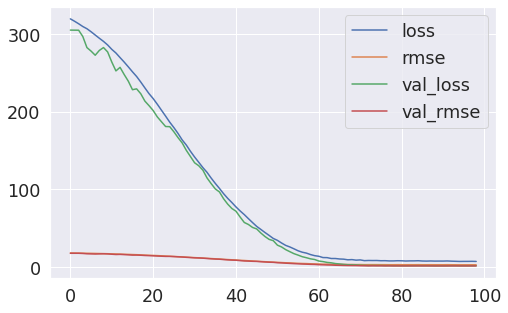

In [ ]:
import matplotlib.pyplot as plt 
history1.params
pd.DataFrame(history1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

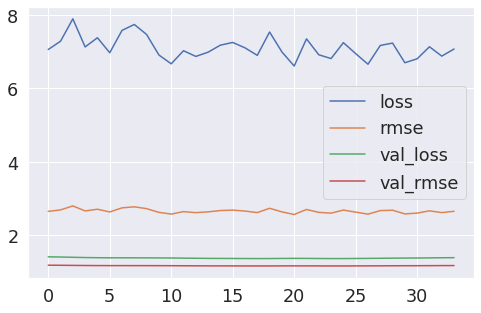

In [ ]:
import matplotlib.pyplot as plt 
history2.params
pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()